# Pothole Detection using YOLOv7
* YOLOv7 Tiny model fixed resolution training.

**Import Libraries**

In [8]:
import os
import glob as glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
from PIL import Image, ImageDraw
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from IPython.display import Image as Dimage

## Data Preprocessing

In [ ]:
# Reading the csv file. Please change the path to your csv file
pothole_df = pd.read_csv('/kaggle/input/potholedataset/train/train/labels.csv')
pothole_df.head()

In [ ]:
#add width and height According to Yolo input
def get_widthheight(image_path):
    img = Image.open(image_path)
    return img.size

In [ ]:
pothole_df['width'],pothole_df['height'] = zip(*('/kaggle/input/potholedataset/train/train/images/'+pothole_df['ImageID']).apply(get_widthheight))
pothole_df.head()

In [ ]:
# First get the list of all classes
classes = pothole_df['LabelName'].unique().tolist()
classes

In [ ]:
# Create a dictionary for storing class to ID mapping
classMap = {}
 
for i,cls in enumerate(classes):
    # Map a class name to an integet ID
    classMap[cls] = i
     
classMap

In [ ]:
# Create the main data folder
!mkdir pothole_dataset
# Create images and labels data folders
!mkdir pothole_dataset/images
!mkdir pothole_dataset/labels
# Create train,val and test data folders for both images and labels
!mkdir pothole_dataset/images/train pothole_dataset/images/valid pothole_dataset/images/test  pothole_dataset/labels/train pothole_dataset/labels/valid pothole_dataset/labels/test

In [ ]:
# Creating the list of images from ImageID
imgs = pothole_df['ImageID'].unique().tolist()
# Loop through each of the image
for img in imgs:
    boundingDetails = []
    # First get the bounding box information for a particular image from the excel sheet
    boundingInfo = pothole_df.loc[pothole_df.ImageID == img,:]
    # Loop through each row of the details
    for idx, row in boundingInfo.iterrows():
        # Get the class Id for the row
        class_id = classMap[row["LabelName"]]
        # Convert the bounding box info into the format for YOLOV5
        # Get the width
        bb_width = row['XMax'] - row['XMin']
        # Get the height
        bb_height = row['YMax'] - row['YMin']
        # Get the centre coordinates
        bb_xcentre = (row['XMin'] + row['XMax'])/2
        bb_ycentre = (row['YMin'] + row['YMax'])/2
        # Normalise the coordinates by diving by width and height
        bb_xcentre /= row['width'] 
        bb_ycentre /= row['height'] 
        bb_width    /= row['width'] 
        bb_height   /= row['height']  
        # Append details in the list 
        boundingDetails.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, bb_xcentre, bb_ycentre, bb_width, bb_height))
    # Create the file name to save this info     
    file_name = os.path.join("pothole_dataset/labels", img.split(".")[0] + ".txt")
    # Save the annotation to disk
    print("\n".join(boundingDetails), file= open(file_name, "w"))

In [ ]:
# Get the list of all annotations
annotations = glob.glob('pothole_dataset/labels' + '/*.txt')
annotations

In [ ]:
# Get the list of images from its folder
imagePath = '/kaggle/input/potholedataset/train/train/images'
images = glob.glob(imagePath + '/*.jpg')
# images

In [ ]:
# Sort the annotations and images and the prepare the train ,test and validation sets
images.sort()
annotations.sort()
 
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 123)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 123)

In [ ]:
#Utility function to copy images to destination folder
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

In [ ]:
# Copy the splits into the respective folders
move_files_to_folder(train_images, 'pothole_dataset/images/train')
move_files_to_folder(val_images, 'pothole_dataset/images/valid/')
move_files_to_folder(test_images, 'pothole_dataset/images/test/')
move_files_to_folder(train_annotations, 'pothole_dataset/labels/train/')
move_files_to_folder(val_annotations, 'pothole_dataset/labels/valid/')
move_files_to_folder(test_annotations, 'pothole_dataset/labels/test/')

## Visualize Images from the Dataset

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))
                
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))
    all_labels = glob.glob(label_paths)
    
    all_images.sort()
    all_labels.sort()

    num_images = len(all_images)
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_images[j])
        with open(all_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize a few training images.
plot(
    image_paths='pothole_dataset/images/train/', 
    label_paths='pothole_dataset/labels/train/*.txt',
    num_samples=4
)

## Repro [YOLOv7](https://github.com/WongKinYiu/yolov7.git)

In [ ]:
if not os.path.exists('yolov7'):
    !git clone https://github.com/WongKinYiu/yolov7.git

In [ ]:
%cd /kaggle/working/yolov7

In [4]:
# !pip install -r requirements.txt
!pip uninstall wandb -y

Found existing installation: wandb 0.12.21
Uninstalling wandb-0.12.21:
  Successfully uninstalled wandb-0.12.21


## Create the Data YAML File

In [ ]:
%%writefile data/pothole.yaml
train: ../pothole_dataset/images/train 
val: ../pothole_dataset/images/valid
test: ../pothole_dataset/images/test

# Classes
nc: 1  # number of classes
names: ['pothole']  # class names

## YOLOv7 Tiny Model Fixed Resolution Training

In [ ]:
# Download the Tiny model weights.
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

In [ ]:
%%writefile cfg/training/yolov7_pothole-tiny.yaml
# parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# yolov7-tiny backbone
backbone:
  # [from, number, module, args] c2, k=1, s=1, p=None, g=1, act=True
  [[-1, 1, Conv, [32, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 0-P1/2  
  
   [-1, 1, Conv, [64, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 1-P2/4    
   
   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 7
   
   [-1, 1, MP, []],  # 8-P3/8
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 14
   
   [-1, 1, MP, []],  # 15-P4/16
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 21
   
   [-1, 1, MP, []],  # 22-P5/32
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 28
  ]

# yolov7-tiny head
head:
  [[-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, SP, [5]],
   [-2, 1, SP, [9]],
   [-3, 1, SP, [13]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -7], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 37
  
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [21, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 47
  
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [14, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P3
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 57
   
   [-1, 1, Conv, [128, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, 47], 1, Concat, [1]],
   
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 65
   
   [-1, 1, Conv, [256, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, 37], 1, Concat, [1]],
   
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 73
      
   [57, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [65, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [73, 1, Conv, [512, 3, 1, None, 1, nn.LeakyReLU(0.1)]],

   [[74,75,76], 1, IDetect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

## Train Model

In [ ]:
!python train.py --epochs 100 --workers 4 --device 0 --batch-size 32 \
--data data/pothole.yaml --img 640 640 --cfg cfg/training/yolov7_pothole-tiny.yaml \
--weights 'yolov7-tiny.pt' --name yolov7_tiny_pothole_fixed_res --hyp data/hyp.scratch.tiny.yaml

## Test Model

In [ ]:
!python test.py --weights runs/train/yolov7_tiny_pothole_fixed_res/weights/best.pt --task test --data data/pothole.yaml

## Inference

In [ ]:
!python detect.py --weights runs/train/yolov7_tiny_pothole_fixed_res2/weights/best.pt --device 0 --source /kaggle/input/potholedataset/test_niF99zC/test/images/676.jpg --save-txt --save-conf

In [ ]:
ImageId = 'runs/detect/exp40/676.jpg'.split('/')[-1]
df = pd.read_csv("runs/detect/exp40/labels/676.txt", sep=" ", header=None)
df.drop(df.columns[[0]], axis=1, inplace=True)
df.rename(columns = {1:'x',2:'y',3:'w',4:'h',5:'Conf'}, inplace = True)
df['LabelName'] = 'pothole'
df['ImageId'] = ImageId
df

## Show Result

In [ ]:
Dimage(filename='runs/detect/exp40/676.jpg')

In [ ]:
!ls /kaggle/working/yolov7/runs/detect/exp/labels

## Predations on test data

In [ ]:
#Get All test Images from test
#!rm -r /kaggle/working/yolov7/runs/detect
test_imagePath = '/kaggle/input/potholedataset/test_niF99zC/test/images/'
test_images = glob.glob(test_imagePath + '/*.jpg')
for img_path in test_images:
    !python detect.py --weights runs/train/yolov7_tiny_pothole_fixed_res2/weights/best.pt --device 0 --source {img_path} --save-txt --save-conf

In [ ]:
%cd /kaggle/working/pothole_dataset
!mkdir detections

In [ ]:
# !ls /kaggle/working/yolov7/runs/detect/exp/labels
detections = []
root = '/kaggle/working/yolov7/runs/detect/'
for path, subdirs, files in os.walk(root):
    for name in files:
        detections.append(os.path.join(path, name))
move_files_to_folder(detections, '/kaggle/working/pothole_dataset/detections')

In [ ]:
!ls /kaggle/working/pothole_dataset/detections

## Create Submission File

In [ ]:
detectionsPath = '/kaggle/working/pothole_dataset/detections'
detectedimages = glob.glob(detectionsPath + '/*.jpg')
detectedimages[1]

In [ ]:
def get_xminyminxmaxymax(row):
    width, height = get_widthheight(row['ImagePath'])
    x = row['x']
    y = row['y']
    w = row['w']
    h = row['h']
    xmin = (width * (2 * x - w))//2
    xmax = (width * (2 * x + w))//2
    ymin = (height * (2 * y - h))//2
    ymax = (height * (2 * y + h))//2
    return xmin, ymin, xmax, ymax

In [ ]:
from os.path import exists
my_submission = pd.DataFrame()
for image_path in detectedimages:
    ImageId = image_path.split('/')[-1]
    text_resutpath = image_path.split('.')[0]+'.txt'
    if exists(text_resutpath):
        df = pd.read_csv(text_resutpath, sep=" ", header=None)
        df.drop(df.columns[[0]], axis=1, inplace=True)
        df.rename(columns = {1:'x',2:'y',3:'w',4:'h',5:'Conf'}, inplace = True)
        df['LabelName'] = 'pothole'
        df['ImageID'] = ImageId
        df['ImagePath'] = image_path
        df['XMin'], df['YMin'], df['XMax'], df['YMax'] = zip(*df.apply(get_xminyminxmaxymax, axis=1))
        df.drop(['x','y','w','h','ImagePath'], axis=1, inplace=True)
        df = df[['XMin', 'YMin', 'XMax', 'YMax','Conf', 'LabelName', 'ImageID']]
        my_submission = pd.concat([my_submission,df])

In [ ]:
my_submission.shape

In [ ]:
my_submission.to_csv('/kaggle/working/pothole_dataset/yolov7results.csv',index=False)

## Out of curiosity 

In [ ]:
!pip install --upgrade setuptools pip --user
!pip install onnx 
!pip install onnxruntime
#!pip install --ignore-installed PyYAML
#!pip install Pillow

!pip install protobuf<4.21.3
!pip install onnxruntime-gpu
!pip install onnx>=1.9.0
!pip install onnx-simplifier>=0.3.6 --user

## Export the model

In [ ]:
!python export.py --weights runs/train/yolov7_tiny_pothole_fixed_res2/weights/best.pt \
        --grid --end2end --simplify \
        --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 \
        --img-size 640 640 --max-wh 640 # For onnxruntime, you need to specify this value as an integer, when it is 0 it means agnostic NMS, 
                     # otherwise it is non-agnostic NMS

## Inference Onnx model

In [ ]:
# Inference for ONNX model
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple
cuda = True
w = "/kaggle/working/yolov7/runs/train/yolov7_tiny_pothole_fixed_res2/weights/best.onnx"

In [ ]:
def detect_pothole(image_path):
    ImageId = image_path.split('/')[-1]
    img = cv2.imread(image_path)

    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
    session = ort.InferenceSession(w, providers=providers)


    def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
        # Resize and pad image while meeting stride-multiple constraints
        shape = im.shape[:2]  # current shape [height, width]
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not scaleup:  # only scale down, do not scale up (for better val mAP)
            r = min(r, 1.0)

        # Compute padding
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

        if auto:  # minimum rectangle
            dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

        dw /= 2  # divide padding into 2 sides
        dh /= 2

        if shape[::-1] != new_unpad:  # resize
            im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
        return im, r, (dw, dh)

    names = ['pothole']
    colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    image = img.copy()
    image, ratio, dwdh = letterbox(image, auto=False)
    image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, 0)
    image = np.ascontiguousarray(image)

    im = image.astype(np.float32)
    im /= 255
    im.shape

    outname = [i.name for i in session.get_outputs()]
    outname

    inname = [i.name for i in session.get_inputs()]
    inname

    inp = {inname[0]:im}
    # ONNX inference
    outputs = session.run(outname, inp)[0]
    df = pd.DataFrame()
    for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
        tempdf = pd.DataFrame([{'XMin':x0, 'YMin':y0, 'XMax':x1, 'YMax':y1, 'Conf':score, 'LabelName':'pothole', 'ImageID':ImageId }])
        df = pd.concat([df, tempdf])
    return df

In [ ]:
# ONNX inference
outputs = session.run(outname, inp)[0]
outputs

In [ ]:
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    print(x0,y0,x1,y1,score)
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

Image.fromarray(ori_images[0])

In [ ]:
df = detect_pothole('/kaggle/working/pothole_dataset/detections/1043.jpg')
# df
my_submission = pd.DataFrame()
count = 1
for image_path in detectedimages:
    df = detect_pothole(image_path)
    my_submission = pd.concat([my_submission,df])
    if count % 100 == 0:
        print('Completed: ',count)
    count+= 1

In [ ]:
# my_submission.shape
my_submission.to_csv('yolov7onnxresults.csv',index=False)

In [ ]:
Dimage(filename='/kaggle/working/pothole_dataset/detections/1043.jpg')

In [ ]:
!cd /kaggle/working/pothole_dataset

In [ ]:
!zip -r /kaggle/working/pothole_dataset.zip /kaggle/working/pothole_dataset

In [ ]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

In [ ]:
%%writefile cfg/training/yolov7_pothole.yaml
# parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
 
# anchors
anchors:
  - [12,16, 19,36, 40,28]  # P3/8
  - [36,75, 76,55, 72,146]  # P4/16
  - [142,110, 192,243, 459,401]  # P5/32
 
# yolov7 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [32, 3, 1]],  # 0
  
  [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2     
  [-1, 1, Conv, [64, 3, 1]],
  
  [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4 
  [-1, 1, Conv, [64, 1, 1]],
  [-2, 1, Conv, [64, 1, 1]],
  [-1, 1, Conv, [64, 3, 1]],
  [-1, 1, Conv, [64, 3, 1]],
  [-1, 1, Conv, [64, 3, 1]],
  [-1, 1, Conv, [64, 3, 1]],
  [[-1, -3, -5, -6], 1, Concat, [1]],
  [-1, 1, Conv, [256, 1, 1]],  # 11
        
  [-1, 1, MP, []],
  [-1, 1, Conv, [128, 1, 1]],
  [-3, 1, Conv, [128, 1, 1]],
  [-1, 1, Conv, [128, 3, 2]],
  [[-1, -3], 1, Concat, [1]],  # 16-P3/8 
  [-1, 1, Conv, [128, 1, 1]],
  [-2, 1, Conv, [128, 1, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [[-1, -3, -5, -6], 1, Concat, [1]],
  [-1, 1, Conv, [512, 1, 1]],  # 24
        
  [-1, 1, MP, []],
  [-1, 1, Conv, [256, 1, 1]],
  [-3, 1, Conv, [256, 1, 1]],
  [-1, 1, Conv, [256, 3, 2]],
  [[-1, -3], 1, Concat, [1]],  # 29-P4/16 
  [-1, 1, Conv, [256, 1, 1]],
  [-2, 1, Conv, [256, 1, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [[-1, -3, -5, -6], 1, Concat, [1]],
  [-1, 1, Conv, [1024, 1, 1]],  # 37
        
  [-1, 1, MP, []],
  [-1, 1, Conv, [512, 1, 1]],
  [-3, 1, Conv, [512, 1, 1]],
  [-1, 1, Conv, [512, 3, 2]],
  [[-1, -3], 1, Concat, [1]],  # 42-P5/32 
  [-1, 1, Conv, [256, 1, 1]],
  [-2, 1, Conv, [256, 1, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [[-1, -3, -5, -6], 1, Concat, [1]],
  [-1, 1, Conv, [1024, 1, 1]],  # 50
  ]
 
# yolov7 head
head:
  [[-1, 1, SPPCSPC, [512]], # 51
  
  [-1, 1, Conv, [256, 1, 1]],
  [-1, 1, nn.Upsample, [None, 2, 'nearest']],
  [37, 1, Conv, [256, 1, 1]], # route backbone P4
  [[-1, -2], 1, Concat, [1]],
  
  [-1, 1, Conv, [256, 1, 1]],
  [-2, 1, Conv, [256, 1, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
  [-1, 1, Conv, [256, 1, 1]], # 63
  
  [-1, 1, Conv, [128, 1, 1]],
  [-1, 1, nn.Upsample, [None, 2, 'nearest']],
  [24, 1, Conv, [128, 1, 1]], # route backbone P3
  [[-1, -2], 1, Concat, [1]],
  
  [-1, 1, Conv, [128, 1, 1]],
  [-2, 1, Conv, [128, 1, 1]],
  [-1, 1, Conv, [64, 3, 1]],
  [-1, 1, Conv, [64, 3, 1]],
  [-1, 1, Conv, [64, 3, 1]],
  [-1, 1, Conv, [64, 3, 1]],
  [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
  [-1, 1, Conv, [128, 1, 1]], # 75
      
  [-1, 1, MP, []],
  [-1, 1, Conv, [128, 1, 1]],
  [-3, 1, Conv, [128, 1, 1]],
  [-1, 1, Conv, [128, 3, 2]],
  [[-1, -3, 63], 1, Concat, [1]],
  
  [-1, 1, Conv, [256, 1, 1]],
  [-2, 1, Conv, [256, 1, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [-1, 1, Conv, [128, 3, 1]],
  [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
  [-1, 1, Conv, [256, 1, 1]], # 88
      
  [-1, 1, MP, []],
  [-1, 1, Conv, [256, 1, 1]],
  [-3, 1, Conv, [256, 1, 1]],
  [-1, 1, Conv, [256, 3, 2]],
  [[-1, -3, 51], 1, Concat, [1]],
  
  [-1, 1, Conv, [512, 1, 1]],
  [-2, 1, Conv, [512, 1, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [-1, 1, Conv, [256, 3, 1]],
  [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
  [-1, 1, Conv, [512, 1, 1]], # 101
  
  [75, 1, RepConv, [256, 3, 1]],
  [88, 1, RepConv, [512, 3, 1]],
  [101, 1, RepConv, [1024, 3, 1]],
 
  [[102,103,104], 1, IDetect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

## YOLOv7 Fixed Resolution Training

In [2]:
%cd /kaggle/working/yolov7

/kaggle/working/yolov7


In [5]:
!python train.py --epochs 100 --workers 4 --device 0 --batch-size 16 --data data/pothole.yaml \
--img 640 640 --cfg cfg/training/yolov7_pothole.yaml --weights 'yolov7_training.pt' \
--name yolov7_pothole_fixed_res --hyp data/hyp.scratch.custom.yaml

wandb: Install Weights & Biases for YOLOR logging with 'pip install wandb' (recommended)
train: Scanning '../pothole_dataset/labels/train.cache' images and labels... 539
val: Scanning '../pothole_dataset/labels/valid.cache' images and labels... 67 fo

autoanchor: Analyzing anchors... anchors/target = 4.27, Best Possible Recall (BPR) = 1.0000
      0/99      9.3G   0.07466   0.01767         0   0.09233        51       640
               Class      Images      Labels           P           R      mAP@.5/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
               Class      Images      Labels           P           R      mAP@.5
                 all          67         125      0.0203         0.2     0.00903  

In [6]:
!python detect.py --source /kaggle/input/potholedataset/test_niF99zC/test/images/676.jpg --weights runs/train/yolov7_pothole_fixed_res2/weights/best.pt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/kaggle/input/potholedataset/test_niF99zC/test/images/676.jpg', update=False, view_img=False, weights=['runs/train/yolov7_pothole_fixed_res2/weights/best.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
3 potholes, Done. (19.6ms) Inference, (1.4ms) NMS
 The image with the resul

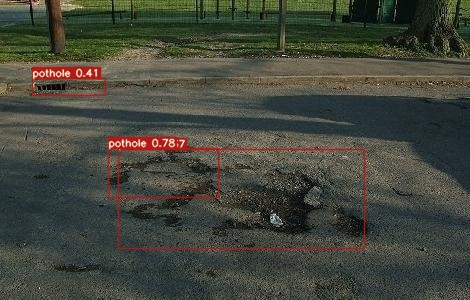

In [9]:
Dimage(filename='runs/detect/exp557/676.jpg')

## YOLOv7 Multi-Resolution Training

In [ ]:
%cd /kaggle/working/yolov7

In [ ]:
!python train.py --epochs 100 --workers 4 --device 0 --batch-size 8 --data data/pothole.yaml \
--img 640 640 --cfg cfg/training/yolov7_pothole.yaml --weights 'yolov7_training.pt' \
--name yolov7_pothole_multi_res --hyp data/hyp.scratch.custom.yaml \
--multi-scale

In [11]:
!python detect.py --source /kaggle/input/potholedataset/test_niF99zC/test/images/676.jpg --weights runs/train/yolov7_pothole_multi_res3/weights/best.pt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/kaggle/input/potholedataset/test_niF99zC/test/images/676.jpg', update=False, view_img=False, weights=['runs/train/yolov7_pothole_multi_res3/weights/best.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2 potholes, Done. (19.5ms) Inference, (1.2ms) NMS
 The image with the resul

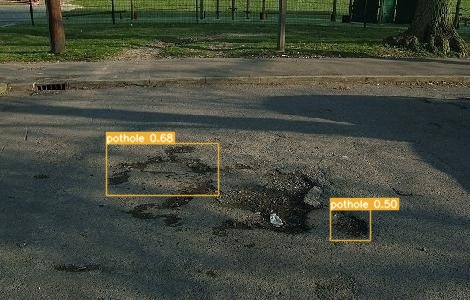

In [12]:
Dimage(filename='runs/detect/exp558/676.jpg')

In [ ]:
!ls /kaggle/working/yolov7/runs/detect

In [ ]:
#Get All test Images from test
!rm -r /kaggle/working/yolov7/runs/detect
test_imagePath = '/kaggle/input/potholedataset/test_niF99zC/test/images/'
test_images = glob.glob(test_imagePath + '/*.jpg')
for img_path in test_images:
    !python detect.py --weights runs/train/yolov7_pothole_multi_res3/weights/best.pt --device 0 --source {img_path} --save-txt --save-conf

In [ ]:
%cd /kaggle/working/pothole_dataset
!mkdir detections_gen

In [ ]:
# !ls /kaggle/working/yolov7/runs/detect/exp/labels
detections = []
root = '/kaggle/working/yolov7/runs/detect/'
for path, subdirs, files in os.walk(root):
    for name in files:
        detections.append(os.path.join(path, name))
move_files_to_folder(detections, '/kaggle/working/pothole_dataset/detections_gen')

In [ ]:
detectionsPath = '/kaggle/working/pothole_dataset/detections'
detectedimages = glob.glob(detectionsPath + '/*.jpg')
detectedimages[1]

In [ ]:
from os.path import exists
my_submission = pd.DataFrame()
for image_path in detectedimages:
    ImageId = image_path.split('/')[-1]
    text_resutpath = image_path.split('.')[0]+'.txt'
    if exists(text_resutpath):
        df = pd.read_csv(text_resutpath, sep=" ", header=None)
        df.drop(df.columns[[0]], axis=1, inplace=True)
        df.rename(columns = {1:'x',2:'y',3:'w',4:'h',5:'Conf'}, inplace = True)
        df['LabelName'] = 'pothole'
        df['ImageID'] = ImageId
        df['ImagePath'] = image_path
        df['XMin'], df['YMin'], df['XMax'], df['YMax'] = zip(*df.apply(get_xminyminxmaxymax, axis=1))
        df.drop(['x','y','w','h','ImagePath'], axis=1, inplace=True)
        df = df[['XMin', 'YMin', 'XMax', 'YMax','Conf', 'LabelName', 'ImageID']]
        my_submission = pd.concat([my_submission,df])

In [ ]:
my_submission.to_csv('/kaggle/working/yolov7_gen.csv',index=False)

In [ ]:
my_submission.shape